### Computer Vision
# An Attempt on Camouflaged Object Detection using Simple Methods
#### Ref Paper : Deng-Ping Fan, Ge-Peng Ji, Guolei Sun, Ming-Ming Cheng, Jianbing Shen, Ling Shao;"Camouflaged object detection", CVPR, 2020 pp. 2777-2787

### References
1. https://learnopencv.com/edge-detection-using-opencv/
2. https://stackoverflow.com/questions/21324950/how-can-i-select-the-best-set-of-parameters-in-the-canny-edge-detection-algorith
3. https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
4. https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/
5. https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

Note : Here we have tried out various simple methods to achieve camouflaged object detection so as to learn from that.  
We have extensievely relied upon the internet to find solutions to issues we stumbled upon as well as to find good examples. These sources are mentioned in the references to maximum extent. Missing references are not an attempt to hide the fact that we have used these sources.

In [48]:
# import the necessary packages
import numpy as np
import os
import cv2 as cv
from matplotlib  import pyplot as plt 

In [49]:
# Read in image
def ReadInImages(dir):
    images = []
    for filename in os.listdir(dir):
        img = cv.imread(os.path.join(dir,filename))
        images.append(img)
    return images

In [50]:
# Display image
def DisplayImage2(image1, image2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    plt.xticks([]), plt.yticks([]) # to hide tick values on X and Y axis
    ax1.imshow(cv.cvtColor(image1,cv.COLOR_BGR2RGB)) 
    ax1.set_title(title1) 
    ax2.imshow(cv.cvtColor(image2,cv.COLOR_BGR2RGB))
    ax2.set_title(title2)
    plt.show()

### Take 1 : Manual Canny Edge Detector Followed by Contour Drawing

In [51]:
dir = '..\Input'
inputs = ReadInImages(dir)
results =[]

In [52]:
#CANNY EDGE DETECTION
in_tk1 = inputs[0] #read in the image
out_edge = cv.Canny(in_tk1,100,250) # apply canny edge detection with manually chosen thresholds
out_edge_clr = cv.cvtColor(out_edge, cv.COLOR_GRAY2RGB)

result_canny_tk1 = cv.add(in_tk1, out_edge_clr) #superimpose the canny edge detection on the original image
results.append(result_canny_tk1)

In [53]:
#CANNY PLUS CONTOUR 
out_edge_gray = cv.cvtColor(out_edge_clr, cv.COLOR_BGR2GRAY)
out_blur = cv.blur(out_edge_gray, (10,10)) #blur image to reduce effect of noise during thresholding
out_ret, out_thresh = cv.threshold(out_blur, 1, 255, cv.THRESH_OTSU) # apply otsu thresholding to the image

out_contours, out_heirarchy = cv.findContours(out_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours in the image
result_contour = cv.drawContours(out_edge_clr, out_contours, -1, (0,255,0), 20) #draw the obtained contour on the output of canny
result_contour = cv.add(in_tk1, result_contour)
results.append(result_contour)

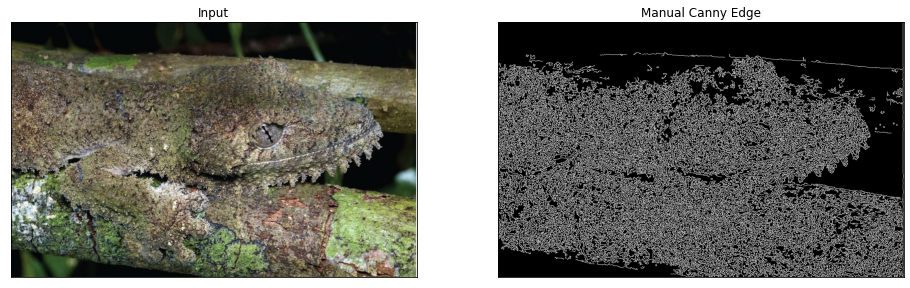

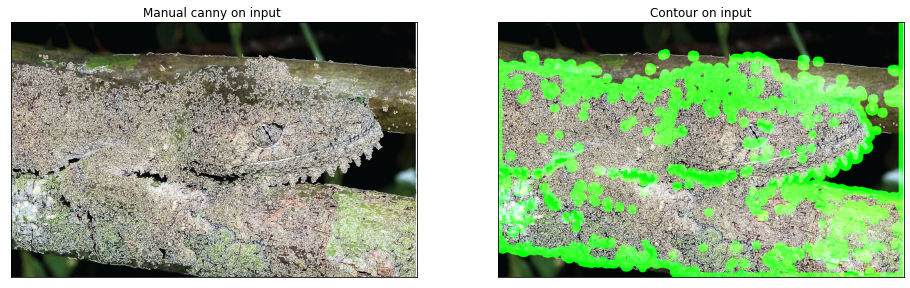

In [54]:
#DISPLAY RESULTS FROM TAKE1
DisplayImage2(in_tk1,out_edge_gray,'Input','Manual Canny Edge')
DisplayImage2(result_canny_tk1,result_contour,'Manual canny on input ','Contour on input')

### Take 2 : Automatic Canny and Texture Extraction using Gabor Filter

In [55]:
def AutoCanny(image, sigma=0.33):
	m = np.median(image) # compute median of single channel pixel intensities
	lower = int(max(0, (1.0 - sigma) * m)) 	# apply automatic Canny edge detection using the computed median
	upper = int(min(255, (1.0 + sigma) * m))
	auto_edge = cv.Canny(image, lower, upper)
	return auto_edge # return the edged image

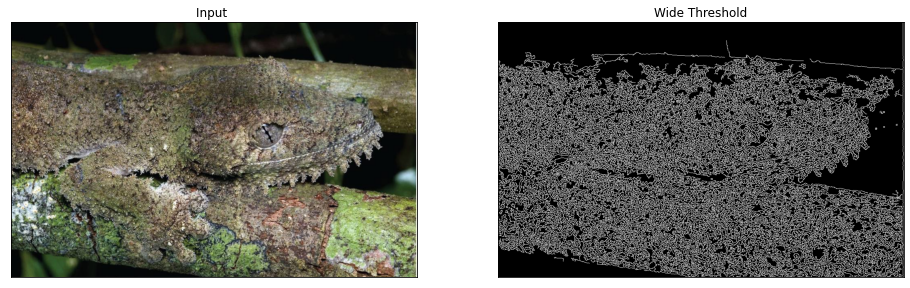

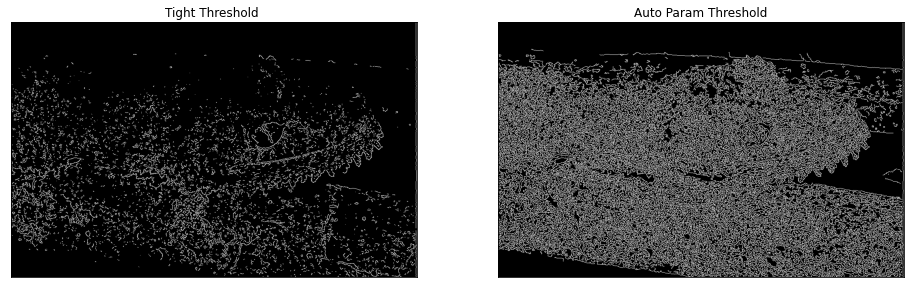

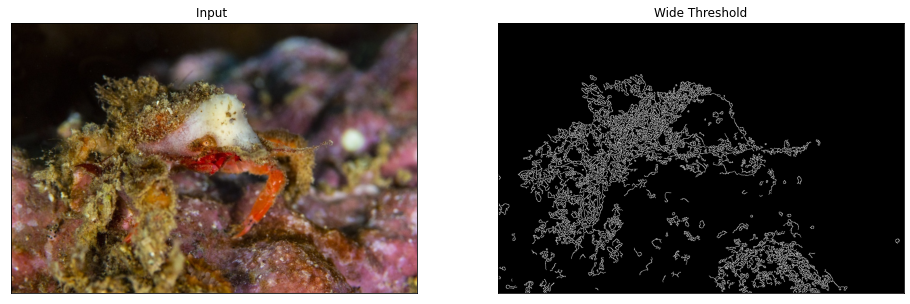

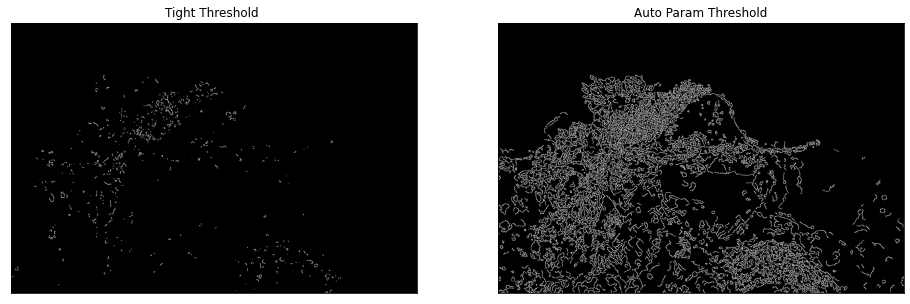

In [56]:
# AUTOMATIC CANNY APPLIED ON INPUT IMAGES
for input in inputs:
    out_gray = cv.cvtColor(input, cv.COLOR_BGR2GRAY) # convert to grayscale
    out_blur = cv.GaussianBlur(out_gray, (3, 3), 0) # apply Gaussian blur to reduce effect of noise
    
    out_wide = cv.Canny(out_blur, 10, 200) # Canny edge detection using a wide threshold
    out_tight = cv.Canny(out_blur, 225, 250) #  Canny edge detection using tight threshold
    out_auto = AutoCanny(out_blur) # Canny edge detection using automatically determined threshold
    out_auto_canny = cv.cvtColor(out_auto, cv.COLOR_GRAY2BGR)
    #DISPLAY RESULTS OF AUTOMATIC THRESHOLD CANNY, WIDE THRESHOLD AND TIGHT THRESHOLD
    DisplayImage2(input,out_wide,'Input ','Wide Threshold')
    DisplayImage2(out_tight,out_auto_canny,'Tight Threshold ','Auto Param Threshold')
    results.append(out_wide)
    results.append(out_tight)
    results.append(out_auto_canny)

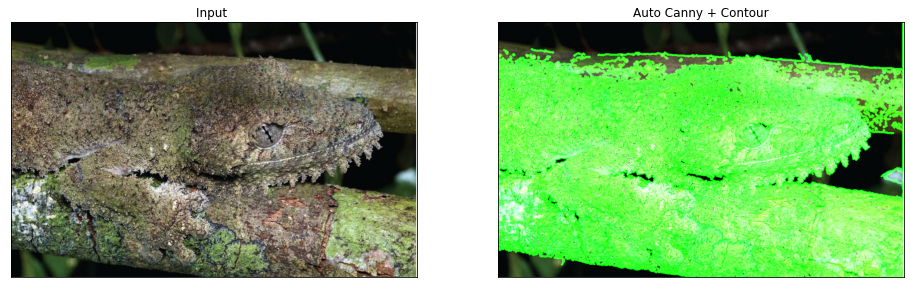

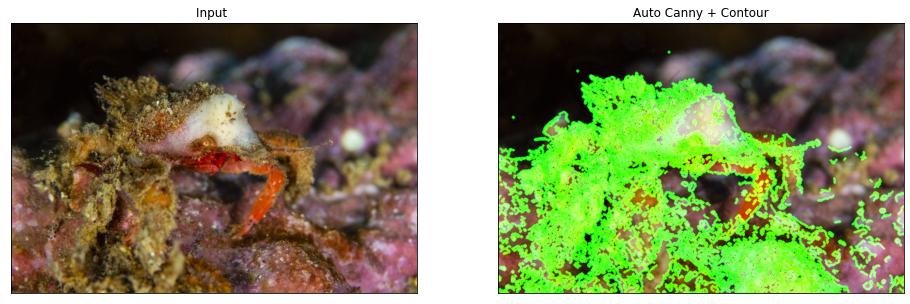

In [71]:
#AUTOMATIC CANNY PLUS CONTOUR
for input in inputs:
    out_gray = cv.cvtColor(input, cv.COLOR_BGR2GRAY) # convert to grayscale

    out_auto = AutoCanny(out_gray) # Canny edge detection using automatically determined threshold
    out_auto_canny = cv.cvtColor(out_auto, cv.COLOR_GRAY2BGR)
    out_blur = cv.GaussianBlur(out_auto, (3, 3), 0) # apply Gaussian blur to reduce effect of noise
    out_ret, out_thresh = cv.threshold(out_blur, 1, 255, cv.THRESH_OTSU) # apply otsu thresholding to the image
    out_contours, out_heirarchy = cv.findContours(out_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours in the image
    cv.drawContours(out_auto_canny, out_contours, -1, (0,255,0), 3) #draw the obtained contour on the output of canny
    result_auto_canny_contour = cv.add(input, out_auto_canny)
    
    #DISPLAY RESULTS OF AUTOMATIC THRESHOLD CANNY AND CONTOUR
    DisplayImage2(input,result_auto_canny_contour,'Input ','Auto Canny + Contour')
    results.append(result_auto_canny_contour)

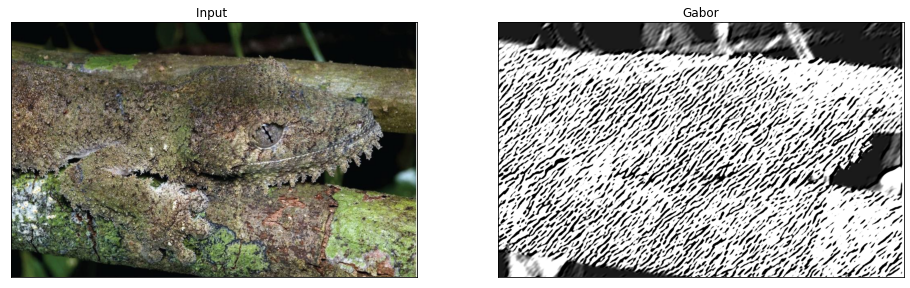

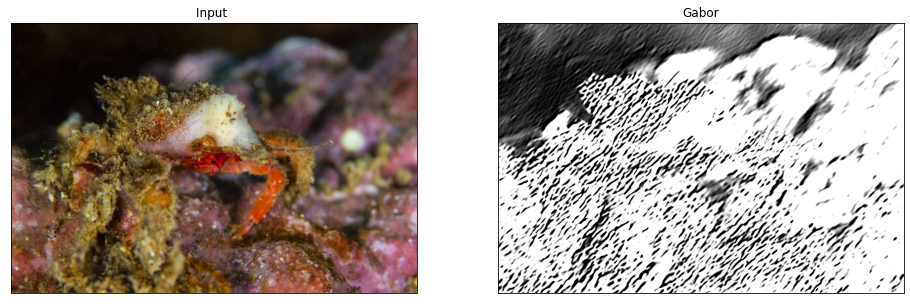

In [58]:
#TEXTURE EXTRACTION USING GABOR
for input in inputs:
    out_gray = cv.cvtColor(input, cv.COLOR_BGR2GRAY) # convert to grayscale
    ksize= 15
    theta=np.pi/4
    kernel=cv.getGaborKernel((ksize,ksize),5.0,theta,10.0,0.9,0,ktype=cv.CV_32F) # apply Gabor filter
    out_gabor = cv.filter2D(out_gray,cv.CV_8UC3,kernel)
    result_gabor = cv.cvtColor(out_gabor, cv.COLOR_GRAY2RGB)
    #DISPLAY RESULTS OF TEXTURE EXTRACTION USING GABOR
    DisplayImage2(input,result_gabor,'Input ','Gabor')
    results.append(result_gabor)

#### K - Means based segmentation on output of Gabor filtering

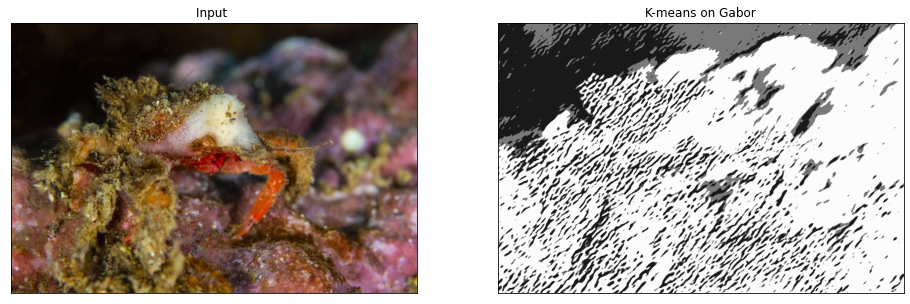

In [59]:
# K-Means based Segmentaion on Result of Gabor
twoDimage = result_gabor.reshape((-1,3))
twoDimage = np.float32(twoDimage)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts=10
ret,label,center=cv.kmeans(twoDimage,K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_kmeans = res.reshape((result_gabor.shape))
DisplayImage2(input,result_kmeans,'Input ','K-means on Gabor')
results.append(result_kmeans)

### Take 3: HOG Feature Extraction

In [60]:
#HOG FEATURE EXTRACTION
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import img_as_ubyte


C:\Users\parva\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


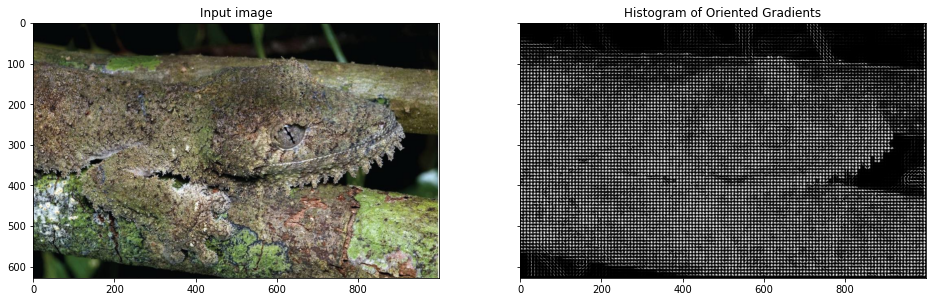

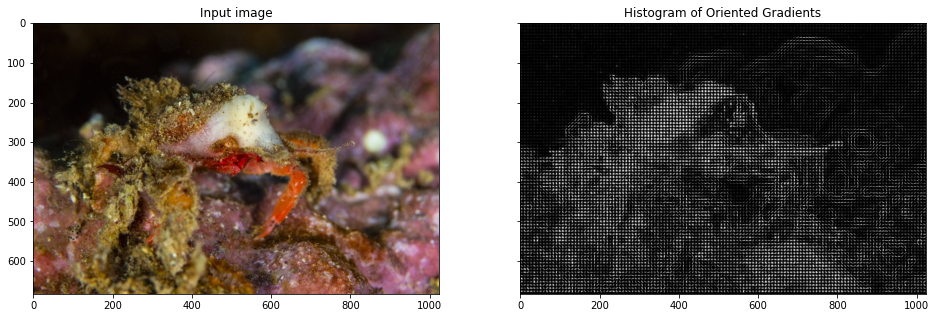

In [61]:
dir = '..\Input'
for filename in os.listdir(dir):
    image_path = os.path.join(dir, filename)
    img = imread(image_path)
    fd, out_hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, multichannel=True)
    hog_image_rescaled = exposure.rescale_intensity(out_hog_image, in_range=(0, 10)) 
    #DISPLAY RESULTS HOG
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) 
    ax1.imshow(img, cmap=plt.cm.gray) 
    ax1.set_title('Input image')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()
    results.append(img_as_ubyte(hog_image_rescaled))

In [62]:
#SAVE RESULTS
path = '..\Output'
num = 1
for result in results:
    cv.imwrite(os.path.join(path , 'result_' + str(num) + '.jpg'), result)
    num += 1